In [68]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
import nltk
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from datetime import timedelta
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
import math
import string 
from six.moves.html_parser import HTMLParser
import urllib2
import json
import time
from functools import wraps
from copy import deepcopy
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import EnglishStemmer
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [43]:
df = pd.read_excel('10_year_data.xlsx')
df['pub_date'] = pd.DatetimeIndex(df['pub_date']).normalize()
#df['pub_date'] = pd.to_datetime(df['pub_date']).normalize()
print 'Number of total articles:', df.shape[0]

Number of total articles: 655600


In [53]:
""" data = pandas dataframe with columns 'pub_date', 'headline', 'paragraph'
    option = 'headline' or 'paragraph' (default = 'headline')
    date_filer = (start date, end date) inclusive; else if default = None, then no filter 
    word_filter = list of words to filter OPTION by (CASE SENSITIVE); default is None
    pos = list of parts of speech tags (default = None)
    stem = boolean, whether or not to stem (default = False)"""

def filter_data(data, option = 'headline', date_filter = None, word_filter = None):
    h = HTMLParser()
    # does not stem stopwords
    stemmer = EnglishStemmer(ignore_stopwords = True)
    
    # filter by dates
    if date_filter is not None:
        start_date, end_date = date_filter
        filtered_data = data[(data['publish_date'] >= start_date) & (data['publish_date'] <= end_date)]
    else:
        filtered_data = data
        
    
    # filter by words
    if word_filter is not None:
        idx_to_drop = [] # store indices of rows that do not contain filter words
        
        # for every article
        for i in range(filtered_data.shape[0]):
            text = filtered_data.iloc[i][option]
            
            # iterates through each filter word
            filter_flag = 0
            # if there is no text (type is not string)
            if isinstance(text, basestring) is False:
                idx_to_drop.append(i)
                continue
            for word in word_filter:
                if word in text:
                    filter_flag = 1
                    break
            # if no filter words in text, drop
            if filter_flag == 0:
                idx_to_drop.append(i)
    
    # drops rows without words in filter
    filtered_data = filtered_data.drop(filtered_data.index[idx_to_drop])
    
    # remove caps
    filtered_data[option] = filtered_data[option].str.lower()
    
    # remove punctuation
    # remove html encoding puncuation from old news
    html_encoding = ['&#8217;', '&#8212;', '&#038;', '&#8230;', '&#8220;', '&#8221;']
    for i in range(filtered_data.shape[0]):
        for encoding in html_encoding:
            if encoding in filtered_data.iloc[i][option]:
                index = filtered_data.index[i]
                filtered_data.loc[index, option] = filtered_data.loc[index, option].replace(encoding, h.unescape(encoding))
    
    # remove other punctuation
    punctuation = list(',.!@#$%^&*()\'\"`:;?' + u'\u2018' + u'\u2019')
    for c in punctuation:
        filtered_data[option] = filtered_data[option].str.replace(c, '')
    
#     # remove stop words
#     for i in range(filtered_data.shape[0]):
#         headline = filtered_data.iloc[i][option]
#         headline = headline.split()
#         new_headline = []
#         for word in headline:
#             if word not in stopwords.words('english'):
#                 new_headline += [word]
        
#         index = filtered_data.index[i]
#         filtered_data.loc[index, option] = ' '.join(new_headline)
                    
    return filtered_data

# makes bag of words given a pre-filtered DF and the option of using title or abstract
def make_bag_of_words(df, option = 'headline'):
    num_articles = df.shape[0]
    words_lst = []
    for i in range(num_articles):
        words_lst += df.iloc[i][option].split()
    
    unique_words = list(set(words_lst))
    print '\nNumber of unique words across all text (including stopwords):', len(unique_words)
    
    # new predictors
    bag_words = np.zeros((df.shape[0], len(unique_words)))
    
    # text of words is a list
    for i in range(num_articles):
        text = df.iloc[i][option].split()
        for word in text:
            word_col_num = unique_words.index(word)
            bag_words[i, word_col_num] += 1
    
    print unique_words[:20]
    print bag_words[:5, :20]
    
    return bag_words, unique_words

def filter_misc(series, pos = None, stem = False):
    new_series = pd.Series(index = series.index)
    for index, text in enumerate(series):
        if stem == True:
            for word in text:
                word = stemmer.stem(word)
        if pos is not None:
            new_series.iloc[index] = ' '.join([y for y,tag in nltk.pos_tag(nltk.word_tokenize(text)) if tag in pos])
    return new_series

In [54]:
filtered_df = filter_data(df, word_filter = ['Apple', 'AAPL', 'iPhone', 'iPod', 'MacBook'], option = 'headline')
print 'Number of articles after filtering:', filtered_df.shape[0]

Number of articles after filtering: 1430


In [55]:
filtered_df.to_excel('10_year_filtered_data.xlsx')

In [ ]:
filtered_df = pd.read_excel('10_year_filtered_data.xlsx')

In [56]:
nltk.pos_tag(nltk.word_tokenize('honoring rw apple in words and food'))

[('honoring', 'VBG'),
 ('rw', 'NN'),
 ('apple', 'NN'),
 ('in', 'IN'),
 ('words', 'NNS'),
 ('and', 'CC'),
 ('food', 'NN')]

In [57]:
filtered_df.head(n=5)

,headline,paragraph,pub_date
424,honoring rw apple in words and food,"About 1,000 of R.W. Apple’s admirers turned ou...",2006-12-06
802,if an ipod gets you through the day this can s...,The XtremeMac Luna is an iPod dock that double...,2006-12-07
1919,apple and its actresses,To the Editor: Re ''She Sings! She Acts! She P...,2006-12-10
2203,sales of ipods and itunes not much in sync,The numbers suggest that iPods are not driving...,2006-12-11
2434,a fund plans to offer a rival slate of directo...,"This is the first time the fund, Breeden Capit...",2006-12-12


In [59]:
filtered_df['headline'] = filter_misc(filtered_df['headline'], pos = ['NN', 'JJ'], stem = False)

In [63]:
vectorizer = CountVectorizer(stop_words = 'english')
vectorized_1gram = vectorizer.fit_transform(filtered_df['headline']).toarray()

In [66]:
# Number of Top words to Look At
num_top_words = 50
bag_to_use = vectorized_1gram
feature_names_to_use = vectorizer.get_feature_names()

# Count the number of time each word occurs in the entire dataset
word_freq = bag_to_use.sum(axis=0)
print word_freq.shape

words = zip(word_freq, feature_names_to_use)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:num_top_words]

print top_words

(1685L,)
[(787, u'apple'), (352, u'iphone'), (78, u'new'), (60, u'ipod'), (42, u'case'), (41, u'music'), (36, u'big'), (35, u'app'), (35, u'china'), (30, u'samsung'), (29, u'google'), (27, u'watch'), (25, u'patent'), (19, u'chief'), (19, u'profit'), (18, u'tax'), (18, u'tv'), (16, u'apps'), (16, u'fbi'), (16, u'service'), (16, u'software'), (16, u'week'), (15, u'ipad'), (15, u'mobile'), (14, u'deal'), (14, u'video'), (13, u'att'), (13, u'book'), (13, u'donald'), (13, u'fight'), (13, u'microsoft'), (13, u'pay'), (13, u'store'), (13, u'trump'), (12, u'tech'), (11, u'court'), (11, u'day'), (11, u'dispute'), (11, u'executive'), (11, u'macbook'), (11, u'phone'), (11, u'privacy'), (11, u'review'), (11, u'rival'), (10, u'cook'), (10, u'market'), (10, u'pie'), (9, u'cake'), (9, u'judge'), (9, u'price')]


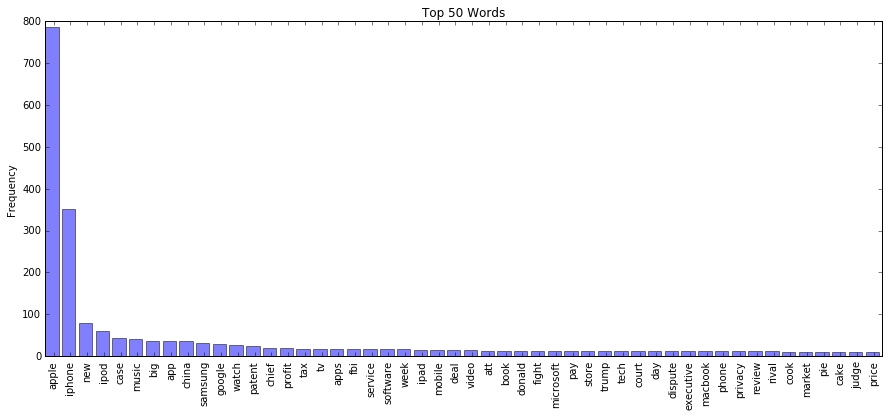

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

#Number of bars to use
indices = np.arange(num_top_words)
#Where to put the label under each bar
width = 0.5
#Bar plot of the frequencies of the top words
ax.bar(indices, [word[0] for word in top_words], color='blue', alpha=0.5)

ax.set_ylabel('Frequency')
ax.set_title('Top ' + str(num_top_words) + ' Words')

#Label the bars with the top words
ax.set_xticks(indices + width)
ax.set_xticklabels([word[1] for word in top_words])

#Turn the labels sideways so they don't overlap
labels = ax.get_xticklabels()
plt.setp(labels, rotation=90, fontsize=10)

plt.show()

In [70]:
# load stock price
stock_price = pd.read_csv('12-4-06-to-12-3-16-Quotes.csv', parse_dates = [0], keep_date_col = True, encoding = 'cp1252')
stock_price.head(n=5)

,date,close,volume,open,high,low
0,2016-12-02,109.90,26481320.0,109.170,110.090,108.85
1,2016-12-01,109.49,37034520.0,110.365,110.940,109.03
2,2016-11-30,110.52,36151450.0,111.600,112.200,110.27
3,2016-11-29,111.46,28507780.0,110.780,112.030,110.07
4,2016-11-28,111.57,27054320.0,111.430,112.465,111.39


In [71]:
""" Function returns the nearest date closest to the given date
        stock_df: a dataframe
        date: a date in date format 
        time_type: "before" or "after"
            "before": finds the nearest business day before the given date
            "after": finds the nearest business day after the given date """
def find_nearest_biz_day(stock_df, date, time_type, counter = 0):
    if counter > 10:
        return None
    price = stock_df[stock_df['date'] == date]['close'].values
    if time_type == 'after':
        # if date exists (i.e., not weekend or holiday)
        if price.size != 0:
            return date
        # if weekend or holiday
        else:
            new_date = date + timedelta(days = 1)
            counter += 1
            return find_nearest_biz_day(stock_df, date + timedelta(days = 1), 'after', counter)
    elif time_type == 'before' or time_type == 'before and done':
        day_before_price = stock_df[stock_df['date'] == date - timedelta(days = 1)]['close'].values
        # if date exists (i.e., not weekend or holiday)
        if price.size != 0 and day_before_price != 0 and time_type == 'before':
            return date - timedelta(days = 1)
        elif price.size != 0 and time_type == 'before and done':
            return date
        # if weekend or holiday
        else:
            counter+= 1
            return find_nearest_biz_day(stock_df, date - timedelta(days = 1), 'before and done', counter)